# Actor-Critic: A2C training

## Imports & setup

### Essential tools

In [1]:
# Generic setup
import math
from operator import itemgetter
import numpy as np
from typing import Tuple, List, Callable
from collections import namedtuple

# For logging and saving results
from datetime import datetime
import os
import timeit

In [2]:
# Analysis
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

### Examine Gym environments

In [3]:
# %%capture
# from gym import envs
# print(envs.registry.all())

In [4]:
import gym

In [33]:
# Smoke test
env = gym.make("CartPole-v1")
# env = gym.make("Pong-v0")
# # Check environment details
# CartPole-v0 is 200, 195.0
# CartPole-v1 is 500, 475.0
# Pong-v0 is 10000, None, 6, 255
env.spec.max_episode_steps, env.spec.reward_threshold, env.action_space, env.observation_space

# Rememeber to make reproducible gym environments
# env.seed(0)

(500,
 475.0,
 Discrete(2),
 Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32))

### Import PyTorch

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducible results
torch.manual_seed(0)

In [6]:
%%capture
!pip install stable_baselines3==1.0

In [7]:
# Import only for multiprocessing
import stable_baselines3
from stable_baselines3.common.env_util import SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed

### Import local modules

In [8]:
from actor_critic import ActorCritic
from utils import stringify_dict

## Set up evaluation

Gym CartPole V0 & V1 description:

>A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Four terminating states for CartPole-v1:
- env.spec.max_episode_steps 500
- env.spec.reward_threshold 475.0
- pole is more than 15 degrees from vertical
- the cart moves more than 2.4 units from the centre

https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f

Doing A2C, a single worker variant of A3C.
- backprop
- keep the hidden layer simple (1)
- ADAM as loss function (RMSprop was very stable as recommended in stable-baselines3, but reward was very poor)
- reward step size/evaluation step size 5

Hyperparameters:
(values from Deep Reinforcement Learning Hands-On, Maxim Lapan)
- num of envs used [6, 12, 24]
- num_episodes [50000, 100000]
- learning rate [0.001, 0.002, 0.003]
- entropy reg weight [0.001, 0.002, 0.003]
- value coefficient [0.1, 0.3, 0.5]
- hidden layers? [(32, 32), (64, 64), (128, 128)]
- max gradient/gradient clipping [0.1]
- Adam optimiser epsilon []
- reward step bootstrapping [5, 10] (Though 10 was very careless earlier)

Performance analysis:
- Reward
- policy loss
- value loss
- overall loss
- ~~No. of timesteps per episode (before terminating state)~~ No need as timesteps == rewards
- No need for wallclock time as we don't want to compare this for now.

Eduard = MSI RX 2080, 6 cores Intel Core i5 9600KF
Fei = 6 cores AMD Ryzen 5 3600, I'm not going to install ROCm

In [13]:
# One episode/test run/logging rewards
def sample_one_episode(env: gym.Env, model: ActorCritic):
    state = env.reset()
    done = False

    total_reward = 0

    while not done:
        state = torch.unsqueeze(torch.FloatTensor(state), 0).to(device)
        probability_dist, values = model(state)
        action_to_take = probability_dist.sample()
        next_state, reward, done, _ = env.step(action_to_take.cpu().detach().numpy()[0])
        state = next_state

        total_reward += reward

    return total_reward
    
def calculate_returns(next_value: torch.Tensor, rewards: List[torch.FloatTensor], masks: List[int], gamma: float) -> List[torch.Tensor]:
    calculated_returns = []
    # Calculate the accumulated returns 
    # from the number of "reward steps to update".
    # Reset R to the next_value first.
    R = next_value

    # Calculate discounted return & go backwards
    for _ in range(len(rewards))[::-1]:
        R = rewards[_] + gamma * R * masks[_]
        # Push return value R
        calculated_returns.insert(0, R)
    return calculated_returns

def plot_rewards_episodes(episode_idx: int, experiment_rewards: list):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Last reward of {experiment_rewards[-1]} after {episode_idx} episodes")
    plt.xlabel("Per 1000 episodes")
    plt.ylabel("Reward")
    plt.plot(experiment_rewards)
    plt.show()

# From: https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/multiprocessing_rl.ipynb

def make_env(env_id: str, rank: int, seed: int = 0) -> Callable:
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    :return: (Callable)
    """
    def _init() -> gym.Env:
        env = gym.make(env_id)
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init


In [14]:
Results = namedtuple("Results", "min_reward, max_reward, reward_variance, mean_reward, mean_actor_loss, mean_critic_loss, mean_entropy_loss, mean_overall_loss")

In [16]:
# Parameters based on environment:
env = gym.make("CartPole-v1")
NUM_OBSERVATIONS: int = env.observation_space.shape[0] # input
NUM_ACTIONS: int = env.action_space.n # output

# Hyperparameters
NUM_ENV_LIST: list = [6, 12, 24]
NUM_EPISODES_LIST: list = [50000, 100000]
LEARNING_RATE_LIST: list = [0.001, 0.002, 0.003]
HIDDEN_LAYER_LIST: list = [(32, 32), (64, 64), (128, 128)]

# Later hyperparameters to try and fix critic
ENTROPY_REG_WEIGHT_LIST: list = [0.001, 0.002, 0.003]
VALUE_COEFFICIENT_LIST: list = [0.1, 0.3, 0.5]

ENTROPY_REG_WEIGHT: float = 0.001 # Entropy regularisation weight/beta/coefficient
VALUE_LOSS_COEFFICIENT: float = 1.0 # Have seen this as 0.5 and 0.1, we will choose the lower
NUM_REWARD_STEPS: int = 5
GAMMA = 0.9
MAX_GRADIENT = 0.1

ENV_NAME = "CartPole-v1"

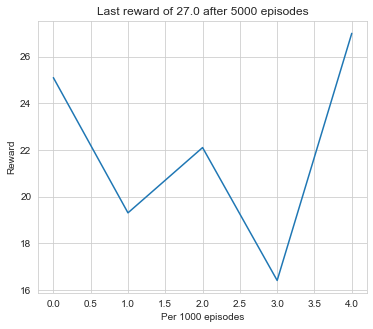

KeyboardInterrupt: 

In [17]:
# Logging stuff
RESULTS_PATH = "results"
EXP_TYPE = "train-a2c"
dt_now = datetime.now()
dt_str = dt_now.strftime("%Y%m%d-%H%M%S")

OUTPUT_PATH = os.path.join(RESULTS_PATH, ENV_NAME, EXP_TYPE, dt_str)

if not os.path.isdir(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

for num_env in list(NUM_ENV_LIST):
    for num_episodes in list(NUM_EPISODES_LIST):
        for lr in list(LEARNING_RATE_LIST):
            for hl in list(HIDDEN_LAYER_LIST):
                # Reset hyperparameter list
                HYPERPARAMETER_LIST = {}

                HYPERPARAMETER_LIST["num_env"] = num_env
                HYPERPARAMETER_LIST["num_episodes"] = num_episodes
                HYPERPARAMETER_LIST["learning_rate"] = lr
                HYPERPARAMETER_LIST["hidden_layers"] = hl
                # print(stringify_dict(HYPERPARAMETER_LIST))

                HYPERPARAMETERS_STR = stringify_dict(HYPERPARAMETER_LIST)
                FILE_NAME = f"{HYPERPARAMETERS_STR}".replace(":", "").replace(" ", "").replace(",", "-").replace("(", "").replace(")", "")
                LOG_FILE_NAME = FILE_NAME + ".txt"
                PLOT_FILE_NAME = FILE_NAME
                MODEL_FILE_NAME = FILE_NAME + ".pt"

                # Time code
                start_time = timeit.default_timer()

                # Create the vectorized environment
                envs = SubprocVecEnv([make_env(ENV_NAME, i) for i in range(num_env)])

                model = ActorCritic(num_inputs=NUM_OBSERVATIONS, num_outputs=NUM_ACTIONS, hidden_layer_config=hl).to(device)
                optimiser = optim.Adam(model.parameters(), lr=lr)

                # Set up results logging
                episode_idx: int = 0
                experiment_rewards: list = []
                experiment_actor_loss: list = []
                experiment_critic_loss: list = []
                experiment_overall_loss: list = []
                experiment_entropy_loss: list = []
                experiment_rewards_var: list = []

                state = envs.reset()

                while episode_idx < num_episodes:

                    # Structures to hold our records for updating
                    log_probs: list = []
                    values: list = []
                    rewards: list = []

                    # entropy: int = 0 # reset Entropy
                    entropy_loss: float = 0
                    # Our thresholding tensors which "turn off" returns
                    # for the next_value (changes them to zero),
                    # if the episode terminates before the 500 max 
                    # timesteps on Cartpole-v1 are reached.
                    masks: list = []

                    for _ in range(NUM_REWARD_STEPS):
                        state = torch.FloatTensor(state).to(device)
                        probability_distribution, state_values = model(state)
                        action_to_take = probability_distribution.sample()

                        next_state, reward, done, _ = envs.step(action_to_take.cpu().numpy())
                        state = next_state

                        # Update all the things:
                        values.append(state_values)

                        log_prob = probability_distribution.log_prob(action_to_take)
                        log_probs.append(log_prob)

                        rewards.append(torch.unsqueeze(torch.FloatTensor(reward),1).to(device))

                        # entropy += probability_distribution.entropy().mean()
                        entropy_loss += -probability_distribution.entropy().mean()

                        # 1 - False = 1; 1 - True = 0
                        # 1 - returns for next value continue to be calculated.
                        masks.append(torch.unsqueeze(torch.FloatTensor(1 - done),1).to(device))

                        # Increment episode counter
                        episode_idx += 1

                        if episode_idx % 1000 == 0:
                            experiment_rewards.append(np.mean([sample_one_episode(env, model) for _ in range(10)]))
                            experiment_rewards_var.append(np.std([sample_one_episode(env, model) for _ in range(10)]))
                            experiment_entropy_loss.append(entropy_loss)
                            plot_rewards_episodes(episode_idx, experiment_rewards)
                        
                    next_state = torch.FloatTensor(next_state).to(device)
                    _, next_state_value = model(next_state)
                    returns = calculate_returns(next_state_value, rewards, masks, GAMMA)
                
                    # Run the next code with no gradients kept, so that 
                    # this can be a bit more efficient.
                    # with torch.no_grad():
                    # Update everything
                    log_probs= torch.cat(log_probs)
                    returns = torch.cat(returns).detach()
                    values = torch.cat(values)

                    advantage = returns - values

                    # Or policy loss
                    actor_loss = -(log_probs * advantage.detach()).mean()
                    experiment_actor_loss.append(actor_loss)

                    # Or value loss - using MSE
                    critic_loss = advantage.pow(2).mean()
                    experiment_critic_loss.append(critic_loss)

                    overall_loss = actor_loss + (VALUE_LOSS_COEFFICIENT * critic_loss) + (ENTROPY_REG_WEIGHT * entropy_loss)
                    experiment_overall_loss.append(overall_loss)

                    # Clear gradients in optimiser to zero
                    # so that we don't accumulate on
                    # past gradients.
                    optimiser.zero_grad()

                    # Propagate loss/weights backwards
                    overall_loss.backward()

                    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRADIENT)
                    # Update model parameters
                    optimiser.step()

                # End timer
                WALL_TIME = timeit.default_timer() - start_time

                # Plot rewards
                plt.plot(experiment_rewards);
                plt.title(f"A2C agent rewards on {ENV_NAME} for {num_episodes} episodes");
                plt.xlabel("Per 1000 episodes");
                plt.ylabel("Reward");
                plt.ylim([0, 500]);
                # plt.ylim([0, 200]); # for CartPole-v0
                plt.xlim([0, 100]);

                last_reward = (num_episodes/1000, experiment_rewards[-1])
                enumerated_rewards = list(enumerate(experiment_rewards))
                min_reward = min(enumerated_rewards, key=itemgetter(1))
                max_reward = max(enumerated_rewards, key=itemgetter(1))

                plt.annotate(f"Last {last_reward[1]}", last_reward)
                plt.annotate(f"Min {min_reward[1]}", min_reward)
                plt.annotate(f"Max {max_reward[1]}", max_reward)
                plt.savefig(os.path.join(OUTPUT_PATH, PLOT_FILE_NAME + "_rewards.png"), dpi=300, bbox_inches="tight");
                plt.show();


                # Plot rewards variance
                plt.plot(experiment_rewards_var);
                plt.title(f"A2C agent rewards variance on {ENV_NAME} for {num_episodes} episodes");
                plt.xlabel("Per 1000 episodes");
                plt.ylabel("Reward variance");
                plt.ylim([0, 200]);
                plt.xlim([0, 100]);

                last_reward_var = (num_episodes/1000, experiment_rewards_var[-1])
                enumerated_rewards_var = list(enumerate(experiment_rewards_var))
                min_reward_var = min(enumerated_rewards_var, key=itemgetter(1))
                max_reward_var = max(enumerated_rewards_var, key=itemgetter(1))
                
                plt.annotate(f"Last {last_reward_var[1]}", last_reward_var)
                plt.annotate(f"Min {min_reward_var[1]}", min_reward_var)
                plt.annotate(f"Max {max_reward_var[1]}", max_reward_var)
                plt.savefig(os.path.join(OUTPUT_PATH, PLOT_FILE_NAME + "_rewards_var.png"), dpi=300, bbox_inches="tight");
                plt.show();


                # Plot actor loss
                experiment_actor_loss_list = [loss.item() for loss in experiment_actor_loss]
                sns.lineplot(data=experiment_actor_loss_list);
                plt.title(f"A2C agent last actor loss of {experiment_actor_loss_list[-1]} after {num_episodes} episodes")
                plt.xlabel("Updates");
                plt.ylabel("Actor Loss");
                plt.ylim([-3, 3]);
                plt.xlim([0, 20000]);
                plt.savefig(os.path.join(OUTPUT_PATH, PLOT_FILE_NAME + "_actor_loss.png"), dpi=300, bbox_inches="tight");
                plt.show();


                # Plot critic loss
                experiment_critic_loss_list = [loss.item() for loss in experiment_critic_loss]
                sns.lineplot(data=experiment_critic_loss_list);
                plt.title(f"A2C agent last critic loss of {experiment_critic_loss_list[-1]} after {num_episodes} episodes")
                plt.xlabel("Updates");
                plt.ylabel("Critic Loss");
                plt.ylim([0, 40]);
                plt.xlim([0, 20000]);
                plt.savefig(os.path.join(OUTPUT_PATH, PLOT_FILE_NAME + "_critic_loss.png"), dpi=300, bbox_inches="tight");
                plt.show();


                # Plot overall loss
                experiment_overall_loss_list = [loss.item() for loss in experiment_overall_loss]
                sns.lineplot(data=experiment_overall_loss_list);
                plt.title(f"A2C agent last overall loss of {experiment_overall_loss_list[-1]} after {num_episodes} episodes")
                plt.xlabel("Updates");
                plt.ylabel("Overall Loss");
                plt.ylim([0, 40]);
                plt.xlim([0, 20000]);
                plt.savefig(os.path.join(OUTPUT_PATH, PLOT_FILE_NAME + "_overall_loss.png"), dpi=300, bbox_inches="tight");
                plt.show();


                # Plot entropy loss
                experiment_entropy_loss_list = [loss.item() for loss in experiment_entropy_loss]
                sns.lineplot(data=experiment_entropy_loss_list);
                plt.title(f"Last entropy loss of {experiment_entropy_loss_list[-1]} after {num_episodes} episodes")
                plt.xlabel("Updates");
                plt.ylabel("Entropy Loss");
                plt.ylim([-5, 5]);
                plt.xlim([0, 100]);
                plt.savefig(os.path.join(OUTPUT_PATH, PLOT_FILE_NAME + "_entropy_loss.png"), dpi=300, bbox_inches="tight");
                plt.show();

                results = Results(min(experiment_rewards), max(experiment_rewards), np.std(experiment_rewards), np.mean(experiment_rewards), np.mean(experiment_actor_loss_list), np.mean(experiment_critic_loss_list), np.mean(experiment_entropy_loss_list), np.mean(experiment_overall_loss_list))

                with open(os.path.join(OUTPUT_PATH, LOG_FILE_NAME), "w") as f:
                    f.write(f"datetime:{dt_str}\n")
                    f.write(f"hyperparameters:{HYPERPARAMETERS_STR}\n")
                    tidy_results = stringify_dict(results._asdict()).replace("-", ":")
                    f.write(f"results:{tidy_results}\n")
                    f.write(f"wall_time:{WALL_TIME}\n")

                with open(os.path.join(OUTPUT_PATH, "all_results.txt"), "a") as f:
                    f.write(f"\n==================================\n")
                    f.write(f"datetime:{dt_str}\n")
                    f.write(f"hyperparameters:{HYPERPARAMETERS_STR}\n")
                    tidy_results = stringify_dict(results._asdict()).replace("-", ":")
                    f.write(f"results:{tidy_results}\n")
                    f.write(f"wall_time:{WALL_TIME}\n")
                    f.write(f"\n==================================\n")


                # Specify a path to save model
                MODEL_PATH = os.path.join(OUTPUT_PATH, MODEL_FILE_NAME)
                torch.save(model, MODEL_PATH)

                # Close envs
                envs.close()


In [49]:
min(experiment_rewards), max(experiment_rewards), np.std(experiment_rewards), np.mean(experiment_rewards)
# VALUE_LOSS_COEFFICIENT = 0.1
# 85.6 218.6, 32.21718150304275

# VALUE_LOSS_COEFFICIENT = 0.5
# (81.8, 242.8, 35.98530639024768, 162.418)

# NUM_EPISODES = 100000
# (101.4, 310.5, 34.232210723235504, 168.143)

# VALUE_LOSS_COEFFICIENT = 0.01
# (84.4, 291.4, 41.10671160528412, 161.66899999999998)

# NUM_REWARD_STEPS: int = 10
# (37.9, 168.4, 22.67719777662134, 81.899)

# lr=0.0001
# (74.7, 224.5, 29.891392389783388, 145.119)

# I changed nothing
# (80.9, 214.8, 29.989488341750683, 133.78300000000002)

# Adam lr: 0.002, gradient clipping: 1 
# The policy is weighted at 1.0, value function at 0.6, entropy at 0.001.
# We go for 10-step bootstrapping, eight workers, and a 0.95 tau.
# (18.0, 468.1, 94.37116402800169, 223.33999999999997)

# 12 workers, 32x32
# (20.2, 428.8, 93.23209095585061, 224.504)
# 12 workers, 128 x 128
# (23.8, 483.7, 110.44132099898115, 258.804)



(17.7, 246.0, 60.88070840586532, 129.212)

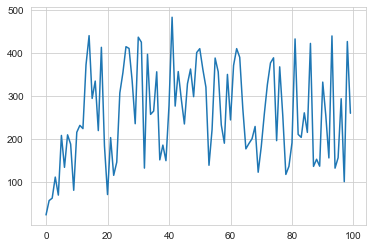

In [257]:
plt.plot(experiment_rewards)
plt.savefig("good-model3.png", dpi=300, bbox_inches="tight")
plt.show()